 # Bi-LSTM
 Base del código de Geeks for Geeks https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/

## Importar datos y librerías

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.utils import resample

Conectamos el drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/Data Tesis/Datos clasificados/'

In [ ]:
# Load your CSV dataset using pandas
df = pd.read_csv(path + 'updated_sentiment_data.csv')

# Assuming your dataset has 'text' and 'label' columns
texts = df['Content'].values
labels = df['Sentiment'].values

# Split into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Convert the data into a TensorFlow dataset
def make_dataset(texts, labels):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    return dataset

train_dataset = make_dataset(train_texts, train_labels)
test_dataset = make_dataset(test_texts, test_labels)

# Batch and shuffle the training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(10000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
# Find the maximum length of text in the 'Content' column
mean_length = df['Content'].apply(len).mean()

print("Mean length of text in 'Content' column:", mean_length)

Mean length of text in 'Content' column: 381.2891666666667


In [ ]:
example, label = next(iter(train_dataset))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b"I know the feeling. I'm too distraught by my own pain at the moment to express more than that but I know the feeling. I just fucking wish I could fix it but I can't."

Label:  5


## Preparar los datos

In [ ]:
path = '/content/drive/MyDrive/Data Tesis/Datos clasificados/'

In [ ]:
# Load your CSV dataset using pandas
df = pd.read_csv(path + 'updated_sentiment_data.csv')

# Filter dataset to only include labels 1, 2, and 3
df = df[df['Sentiment'].isin([1, 2, 3, 5])]

# Separate data by label
df_label_1 = df[df['Sentiment'] == 1]
df_label_2 = df[df['Sentiment'] == 2]
df_label_3 = df[df['Sentiment'] == 3]
df_label_5 = df[df['Sentiment'] == 5]

# Find the maximum count for balancing (based on the largest label count)
target_count = max(len(df_label_1), len(df_label_2), len(df_label_3), len(df_label_5))
print(len(df_label_1))
print(len(df_label_2))
print(len(df_label_3))
print(len(df_label_5))
print(target_count)

91
46
144
916
916


In [ ]:
# Oversample labels 1 and 2 to match the target count
df_label_1_oversampled = resample(df_label_1, replace=True, n_samples=target_count, random_state=42)
df_label_2_oversampled = resample(df_label_2, replace=True, n_samples=target_count, random_state=42)
df_label_3_oversampled = resample(df_label_3, replace=True, n_samples=target_count, random_state=42)

# Combine the balanced data
df_balanced = pd.concat([df_label_1_oversampled, df_label_2_oversampled, df_label_3_oversampled, df_label_5])

# Shuffle the dataset to ensure random distribution
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Extract texts and labels from the balanced dataset
texts = df_balanced['Content'].values
labels = df_balanced['Sentiment'].values

label_mapping = {1: 0, 2: 1, 3: 2, 5: 3}
labels = np.array([label_mapping[label] for label in labels])

# Split into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Convert the data into a TensorFlow dataset
def make_dataset(texts, labels):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    return dataset

train_dataset = make_dataset(train_texts, train_labels)
test_dataset = make_dataset(test_texts, test_labels)

# Batch and shuffle the training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(10000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
example, label = next(iter(train_dataset))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b"I wasn't warned, I wasn't warned by my psychiatrist that I could end up like that, agonizing every minute of every second of every single day.\n\nAntidepressants and other psych drugs damaged my brain and put me in a position I wouldn't wish not even to my worst enemy.\n\nMy sexuality has been obliterated: total loss of libido, erectile dysfunction, reduced sensitivity in genitalia, pleasureless orgasms. Sadly that's just the tip of the iceberg. The main problem here is that my body cannot produce any kind of pleasurable feeling because of the malfunctioning of the brain reward system. I know it seems like it can't be real, but trust me, I can't really enjoy not even a single thing in my life because my reward/dopamine pathaway has been somehow altered. I can't feel hungry or enjoy a (good) meal, I can't feel the endorphins rush/good sensations after a sport session, I can't feel the effect of most drugs (coffee, nicotine, alcohol, heroin, you name it\xe2\x80\xa6). My body is 

## Modelo

### Encoder

In [ ]:
def calculate_average_length(dataset):
    lengths = []
    for text, _ in dataset:
        # Convert the tensor to a numpy array and then to a list of strings
        # Assuming text is a 1D tensor
        text_list = text.numpy().tolist()  # Convert to list of strings
        for t in text_list:
            lengths.append(len(t.split()))  # Count the number of tokens
    return sum(lengths) // len(lengths) if lengths else 0  # Handle empty case

# Calculate average sequence length in train_dataset
avg_length = calculate_average_length(train_dataset)
print("Average text length:", avg_length)

Average text length: 117


In [ ]:
# Using the TextVectorization layer to normalize, split, and map strings
# to integers.
encoder = tf.keras.layers.TextVectorization(
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=min(512, int(avg_length * 1.5))  # Adjust as needed
)
encoder.adapt(train_dataset.map(lambda text, label: text))

# Extracting the vocabulary from the TextVectorization layer.
vocabulary = np.array(encoder.get_vocabulary())

# Encoding a test example and decoding it back.
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b"I wasn't warned, I wasn't warned by my psychiatrist that I could end up like that, agonizing every minute of every second of every single day.\n\nAntidepressants and other psych drugs damaged my brain and put me in a position I wouldn't wish not even to my worst enemy.\n\nMy sexuality has been obliterated: total loss of libido, erectile dysfunction, reduced sensitivity in genitalia, pleasureless orgasms. Sadly that's just the tip of the iceberg. The main problem here is that my body cannot produce any kind of pleasurable feeling because of the malfunctioning of the brain reward system. I know it seems like it can't be real, but trust me, I can't really enjoy not even a single thing in my life because my reward/dopamine pathaway has been somehow altered. I can't feel hungry or enjoy a (good) meal, I can't feel the endorphins rush/good sensations after a sport session, I can't feel the effect of most drugs (coffee, nicotine, alcohol, heroin, you name it\xe2\x80\xa6). My body

In [ ]:
# Adjusting the final layer and using softmax for multiclass classification
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),  # Use shape (1,) for each string entry
    encoder,  # Text encoder layer (like TextVectorization) to convert strings to sequences
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # Assuming 7 classes for softmax
])

# Summary of the model
model.summary()

# Compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # For integer-encoded labels
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ (None, 175)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 175, 64)             │         446,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 175, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 558,340 (2.13 MB)

 Trainable params: 558,340 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model and validating it on test set
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 578ms/step - accuracy: 0.4058 - loss: 1.2246 - val_accuracy: 0.8622 - val_loss: 0.4556
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 533ms/step - accuracy: 0.9155 - loss: 0.2768 - val_accuracy: 0.9468 - val_loss: 0.1483
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 532ms/step - accuracy: 0.9781 - loss: 0.0695 - val_accuracy: 0.9727 - val_loss: 0.0874
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 532ms/step - accuracy: 0.9877 - loss: 0.0399 - val_accuracy: 0.9727 - val_loss: 0.0980
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 537ms/step - accuracy: 0.9992 - loss: 0.0140 - val_accuracy: 0.9795 - val_loss: 0.0807


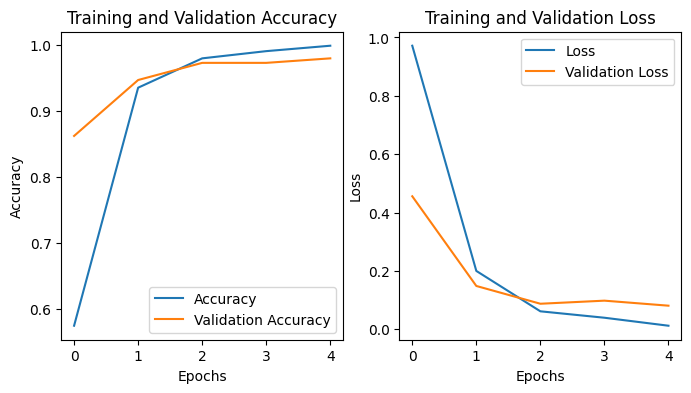

In [ ]:
# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

## Model Metrics

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report

true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_classes)
print(f'Accuracy: {accuracy:.4f}')

# Calculate recall
recall = recall_score(true_labels, predicted_classes, average='weighted')  # Use 'macro', 'micro', or 'weighted' as needed
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_classes, average='weighted')  # Use 'macro', 'micro', or 'weighted' as needed
print(f'F1 Score: {f1:.4f}')

print("\nClassification Report:\n", classification_report(true_labels, predicted_classes))


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step
Accuracy: 0.9795
Recall: 0.9795
F1 Score: 0.9794

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       179
           1       0.99      1.00      1.00       174
           2       0.97      0.98      0.98       189
           3       0.98      0.94      0.96       191

    accuracy                           0.98       733
   macro avg       0.98      0.98      0.98       733
weighted avg       0.98      0.98      0.98       733



## Save model

In [ ]:
model.save('my_model.keras')

In [ ]:
from google.colab import files

# Download the Keras model file
files.download('my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Predicciones

In [ ]:
path = '/content/drive/MyDrive/Data Tesis/Modelos'

In [ ]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model(path + '/my_model.keras')

# Example text to classify
text_input = ["I know how I'm gonna kill mayself, I know the time and the place, wish me luck"]

predictions = model(tf.constant(text_input))
predicted_class = tf.argmax(predictions, axis=-1).numpy()  # Get the predicted class index
print("Predicted class:", predicted_class)

Predicted class: [3]


In [ ]:
# Load the model
model = tf.keras.models.load_model(path + '/my_model.keras')

# Example text to classify
text_input = ["I know how I'm gonna kill mayself, I know the time and the place, wish me luck"]

predictions = model(tf.constant(text_input))
predictions_percent = predictions.numpy()  # Convert to percentages

print(predictions_percent)

for i, percent in enumerate(predictions_percent[0], 1):  # assuming single input
    print(f"Label {i}: {percent:.2f}%")

[[1.1440604e-03 5.5347711e-05 2.8477035e-02 9.7032350e-01]]
Label 1: 0.00%
Label 2: 0.00%
Label 3: 0.03%
Label 4: 0.97%
